# Introduction

Looking at the transaction data, we can see that women's items are frequently purchased.  
Are women the only users?

In this notebook, we analyze whether we can guess the gender of users based on their purchase history.

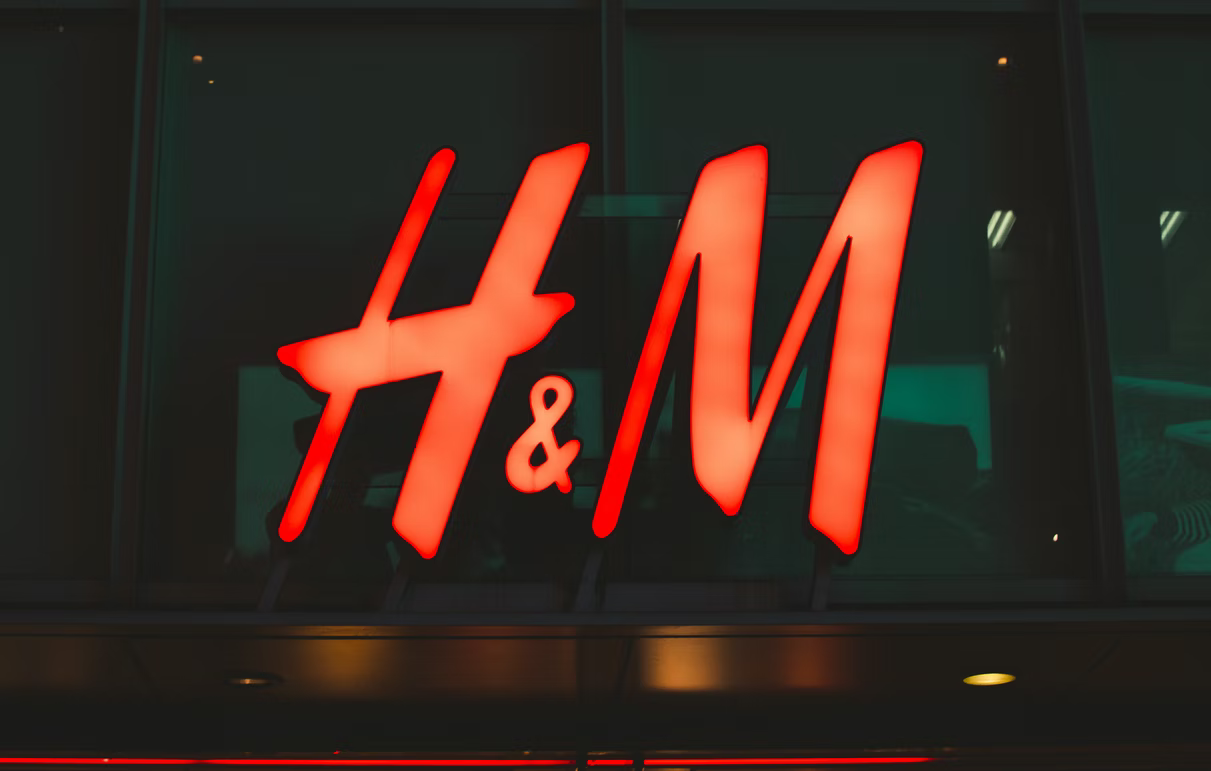

# Import

In [ ]:
import sys
import os
import json
import time
import re
import random
import datetime
import pickle
import gc
import warnings
import joblib
import logging
from functools import wraps
import psutil
import math
import multiprocessing
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.5f}'.format
%matplotlib inline
sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context({"lines.linewidth": 3})

# Setting Logger

In [ ]:
def elapsed_time(logger):
    def _elapsed_time(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start = time.time()
            p = psutil.Process(os.getpid())
            m0 = p.memory_info()[0] / 2. ** 30
            logger.info(f'***** Beg: {func.__name__} *****')
            v = func(*args, **kwargs)
            m1 = p.memory_info()[0] / 2. ** 30
            delta = m1 - m0
            sign = '+' if delta >= 0 else '-'
            delta = math.fabs(delta)
            logger.info(
                f'***** End: {func.__name__} {time.time() - start:.2f}sec [{m1:.1f}GB({sign}{delta:.1f}GB)] *****')
            return v
        return wrapper
    return _elapsed_time


def get_logger(loglevel: str = 'info', out_file: str = None, handler: bool = True):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s [%(levelname)5s] %(message)s")

    if loglevel == 'info':
        loglevel = logging.INFO
    elif loglevel == 'debug':
        loglevel = logging.DEBUG
    else:
        loglevel = logging.INFO

    if handler:
        if out_file is None:
            handler = logging.StreamHandler(sys.stdout)
        else:
            handler = logging.FileHandler(out_file)
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    logger.setLevel(loglevel)

    return logger

LOGGER = get_logger()

# Load Data

In [ ]:
@elapsed_time(LOGGER)
def load_data(dir_name):
    articles_df = pd.read_csv(os.path.join(dir_name, "articles.csv"))
    customers_df = pd.read_csv(os.path.join(dir_name, "customers.csv"))
    sample_submission_df = pd.read_csv(os.path.join(dir_name, "sample_submission.csv"))
    transactions_train_df = pd.read_csv(os.path.join(dir_name, "transactions_train.csv"))
    return articles_df, customers_df, sample_submission_df, transactions_train_df

In [ ]:
articles_df, customers_df, sample_submission_df, transactions_train_df = load_data('../input/h-and-m-personalized-fashion-recommendations')

# How to distinguish between female and male items

- `articles` has a column 「index_group_name」.
- In this column, there is a description of whether the product is for men or women.
    - Menswear or Ladieswear

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(data=articles_df, y='index_group_name', color='blue')
ax.set_xlabel('count by index_group_name')
ax.set_ylabel('index_group_name')
plt.show()

In [ ]:
articles_df['index_group_name'].value_counts().reset_index()

# Look at the users who are buying each item "Ladieswear" / "Menswear".

In [ ]:
# image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
image_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/images/'

def plot_image_samples(articles_df, tran_df, article_id_list, image_path, cols=1, rows=-1):
    try:
        _df = articles_df.loc[articles_df['article_id'].isin(article_id_list)][['article_id', 'prod_name', 'product_group_name', 'product_type_name', 'index_group_name', 'index_name', 'detail_desc']]
        _df = pd.merge(tran_df, _df, how='left', left_on='article_id', right_on='article_id').sort_values('t_dat', ascending=False)
        _df.loc[:, 'image_id'] = _df['article_id'].apply(lambda x: '0'+str(x))

        article_ids = _df.image_id.values[0:cols*rows]
        prod_names = _df.prod_name.values[0:cols*rows]
        product_group_names = _df.product_group_name.values[0:cols*rows]
        product_type_name = _df.product_type_name.values[0:cols*rows]
        index_group_name = _df.index_group_name.values[0:cols*rows]
        index_name = _df.index_name.values[0:cols*rows]
        buy_dates = _df.t_dat.values[0:cols*rows]
        prices = _df.price.values[0:cols*rows]
        sales_channel_ids = _df.sales_channel_id.values[0:cols*rows]

        plt.figure(figsize=(4 + 3 * cols, 5 + 5 * rows))
        for i in range(cols * rows):
            article_id = article_ids[i][-10:]
            plt.subplot(rows, cols, i+1)
            plt.axis('off')
            plt.title(f"{prod_names[i]}\n{product_group_names[i]} - {product_type_name[i]}\n{index_group_name[i]} - {index_name[i]}\n{buy_dates[i]}\n{round(prices[i], 4)} | {sales_channel_ids[i]}\n{article_id}.jpg")
            image = Image.open(f"{image_path}{article_id[:3]}/{article_id}.jpg")
            plt.imshow(image)
    
    except Exception as e:
        pass

## Ladieswear

In [ ]:
article_show_col = ['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc']

In [ ]:
articles_df[articles_df['index_group_name'] == 'Ladieswear'].sample(5, random_state=42)[article_show_col]

In [ ]:
# Sample data for purchasing Ladieswear items
transactions_train_df[transactions_train_df['article_id'] == 821163010].sample(5, random_state=42)

In [ ]:
c_id = 'f340161bc34d1db6557da80948f03751cd33ecfb7e8d4026ea4306edd510abe7'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

In [ ]:
c_id = '6c095ae6fe1468344f4b4fe005a4541bbb925ed260fe240d671689b9f8d8007a'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

From the data, we can infer that they are female.

Now, let's take a look at the data for men's purchases.

## Menswear

In [ ]:
articles_df[articles_df['index_group_name'] == 'Menswear'].sample(5, random_state=45)[article_show_col]

In [ ]:
transactions_train_df[transactions_train_df['article_id'] == 700883002].sample(5, random_state=42)

In [ ]:
c_id = 'b70c7ca6b0c83125edbbf3c24f99663d4261f5b70393a118688dfd32e93273d3'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

In [ ]:
c_id = 'cadbc01685cbdee0eccf3517506fc07a9ffa25e279359521b654c567a549c6d9'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

As can be seen from these figures, it is possible that a large number of women are mixed in with the users who are purchasing male items.


So are there no men?  
Let's see if there is any data on the purchase of only men's items.

# Look at users who buy only men's items.


In [ ]:
mens_wear_article = articles_df[articles_df['index_group_name'] == 'Menswear']
mens_wear_article.shape

In [ ]:
temp_tran_df = transactions_train_df.copy()
temp_tran_df['is_mens_wear'] = 0

temp_tran_df.loc[temp_tran_df['article_id'].isin(mens_wear_article['article_id'].tolist()), 'is_mens_wear'] = 1

buy_sum_df = temp_tran_df.groupby('customer_id')['article_id'].count().reset_index()
buy_mens_df = temp_tran_df[temp_tran_df['is_mens_wear'] == 1].groupby('customer_id')['article_id'].count().reset_index()
buy_count_df = pd.merge(buy_sum_df, buy_mens_df, how='left', on='customer_id').rename(columns={'article_id_x': 'buy_all', 'article_id_y': 'buy_mens'})

buy_count_df = buy_count_df.fillna(0)
buy_count_df['buy_mens'] = buy_count_df['buy_mens'].astype('int')

In [ ]:
buy_count_df

In [ ]:
buy_count_df.loc[:, 'buy_diff'] = buy_count_df['buy_all'] - buy_count_df['buy_mens']

In [ ]:
buy_count_df

In [ ]:
buy_count_df[buy_count_df['buy_diff'] == 0]

Looks like we have about 26257 men!? 

Let's take a closer look at the data we purchased.

# Menswear 〜buy only men's items〜

In [ ]:
c_id = '000231cc9af9e58ab4edc66fbd61da921b144ba85bc1c00d0ae2309531e4c210'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

In [ ]:
c_id = '2fdd9d5462f42bee90547a8feceacba88a5b3d71dcb0f77c975a41c26dcbb4d7'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

In [ ]:
c_id = 'fff8eafb387d2052bffa46ed05c9333e4dd50d86f1511277d2db43d7c33d63fd'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

As you can see, there seems to be a certain number of male users!

(However, it's possible that there are women who only buy male items.)

## If you look at the data a little more carefully...

In [ ]:
c_id = '235b8dab472251f9551ed2123eeba1a8b3c599a164b38029a7fd526cae795be1'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

In [ ]:
c_id = 'afcd22fe154f9c3bd68f07d69bcf68c7c26f8b1073845a075a8d00a7bb3a6663'
temp_tran_df = transactions_train_df[transactions_train_df['customer_id'] == c_id]
LOGGER.info(f'tran shape is {temp_tran_df.shape}')
image_path = '../input/h-and-m-personalized-fashion-recommendations/images/'
plot_image_samples(articles_df, temp_tran_df, temp_tran_df['article_id'].tolist(), image_path, cols=6, rows=3)

It shows that a certain number of users are only buying the same items on the same day!

What does this mean? Is it a purchase for resale?

At the very least, there should be no need to buy dozens of items just to wear them yourself.

If anyone knows anything about it, please let me know in the comments.



Thanks for reading my notebook!

If you like it, I'd love it if you'd upvote!😊

# EOF